In [2]:
import numpy as np
import pandas as pd
import pymc3 as pm
from tqdm import trange
import matplotlib.pyplot as plt
from scipy.stats import distributions as D
import numba
import seaborn as sns
plt.style.use('bmh')

%matplotlib inline

# Algorithm 8

Applying alogrithm 8 from Neal 2000 to galaxy data.

In [3]:
galaxy = pd.read_csv('./galaxy.csv', index_col=[0], dtype=np.float).values
galaxy = (galaxy - galaxy.mean()) / galaxy.std()  # Standardize

## Code

Numba is used to accelerate by a factor of 100x

In [4]:
@numba.decorators.autojit
def fastLLK(data, mu, std):
    first = (-.5) * np.log(2. * np.pi * std)
    second = - (1. / (2. * std)) * np.square(data - mu)
    return np.exp(first + second)

@numba.decorators.autojit
def fastLLK2(data, mu, std):
    N = len(data)
    first = N * (-.5) * np.log(2. * np.pi * std)
    second = - (1. / (2. * std)) * np.square(data - mu)
    return np.exp(first + second.sum())

@numba.decorators.autojit
def minMaxScale(probs):
    min_val = probs.min()
    minMaxProbs = (probs - min_val) / (probs.max() - min_val)
    scale_probs = minMaxProbs / minMaxProbs.sum()
    return scale_probs

def draw_assignment(c_llk, a_llk):
    probs = np.concatenate((c_llk, a_llk))
    scale_probs = minMaxScale(probs)
    choice_cluster = np.argmax(np.random.multinomial(1, scale_probs))
    return choice_cluster

@numba.decorators.autojit
def mcmc(data, mu, std, exp=0.05):
    muProposed = np.random.normal(mu, exp)
    stdProposed = proposal_dist(std)
    ratio = fastLLK2(data, muProposed, stdProposed) / fastLLK2(data, mu, std)
    prob_acp = min(1, ratio)
    accept = np.random.rand() < prob_acp
    if accept:
        return muProposed, stdProposed
    else:
        return mu, std

@numba.decorators.autojit
def proposal_dist(value):
    """Draw a sample from the proposal distribution
    """
    pStar = np.random.uniform(value - 0.2, value + .2)
    if pStar < 0:
        pStar = abs(pStar)
    if pStar > 2:
        pStar = 2 - (pStar % 2)

    return pStar

In [5]:
class Observation(object):
    """Used for managing cluster assignments"""
    def __init__(self, data):
        self.data = data
        self.cluster = None
        self.assignments = []

    def assign_cluster(self, new_cluster):

        if self.cluster is None:
            self.cluster = new_cluster
            self.cluster.assign_obs(self.data)
        else:
            self.cluster.pop_obs(self.data)
            self.cluster = new_cluster
            self.cluster.assign_obs(self.data)
        self.assignments.append(new_cluster.id)

class Cluster(object):
    """Object for describing a cluster"""
    def __init__(self, mu, std, id=0):

        self.std = std
        self.mu = mu
        self.id = id

        self.histMu = [mu]
        self.histStd = [std]
        self.size = 0
        self.points = []
        
    def assign_obs(self, obs):
        self.points.append(float(obs))
        self.size += 1
    
    def pop_obs(self, obs):
        self.points.remove(obs)
        self.size -= 1

    def run_mcmc(self):
        points = np.array(self.points)
        self.mu, self.std = mcmc(points, self.mu, self.std)
        self.histMu.append(self.mu)
        self.histStd.append(self.std)
        
    def reparameterize(self, burn, stride):
        self.mu = np.mean(self.histMu[burn::stride])
        self.std = np.mean(self.histStd[burn::stride])

## Simulation

### Initialize

In [6]:
ALPHA = 1  # Dispersion parameters
M = 30  # 
AUX_PROP = float(ALPHA) / M
CLUSTER_NUM = 0
MCMC_SIMS = 20000
SIMS = 10

clusters = []
assignments = []
for d in galaxy:
    assignments.append(Observation(d))

### Run DP Algorithm

In [37]:
num_clusters = []
for i in trange(SIMS):
    for obs in assignments:
        aux_params = np.vstack([np.random.normal(0, 5, size=M), np.abs(np.random.normal(0, 1.5, size=M)) + .05]).T #
        # Probabilities
        aux_llks = np.array([fastLLK(obs.data, p, s) * AUX_PROP for p, s in aux_params]).flatten()
        cl_llks = np.array([fastLLK(obs.data, c.mu, c.std) * c.size for c in clusters]).flatten()
        choice_cluster = draw_assignment(cl_llks, aux_llks)
        # Assign observation
        if choice_cluster > len(clusters) - 1:
            p, s = aux_params[choice_cluster - len(clusters)]
            aux_choice = Cluster(p, s, CLUSTER_NUM)
            CLUSTER_NUM += 1
            clusters.append(aux_choice)
            obs.assign_cluster(aux_choice)
        else:
            cluster = clusters[choice_cluster]
            obs.assign_cluster(cluster)
        # Delete clusters without data point
        clusters = [c for c in clusters if c.size > 0]
    num_clusters.append(len(clusters))
    # RUN MCMC

    for _ in xrange(MCMC_SIMS):
        [c.run_mcmc() for c in clusters]
    # Burn chain
    BURN = 5000
    STRIDE = 10
    [c.reparameterize(BURN, STRIDE) for c in clusters];

100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


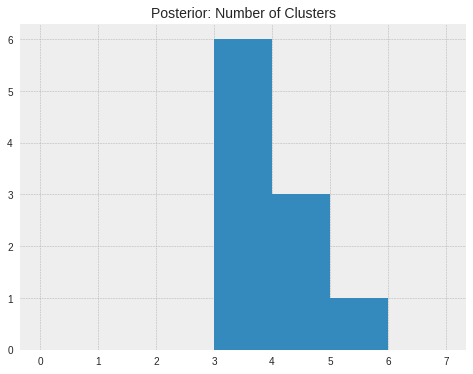

In [42]:
plt.figure(figsize=(8, 6))
plt.title('Posterior: Number of Clusters', fontsize=14)
plt.hist(num_clusters, range(0,8));

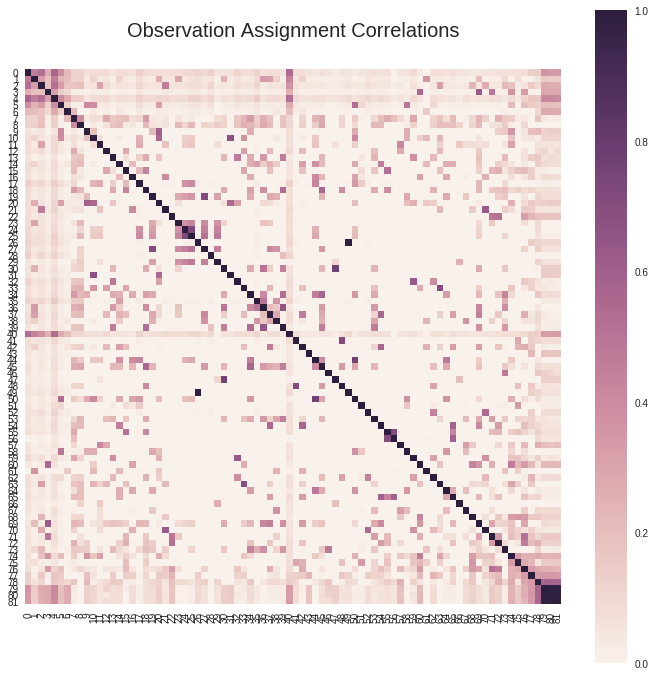

In [39]:
data = []
for obs in sorted(assignments, key=lambda x: x.data):
    data.append(obs.assignments)
plt.figure(figsize=(12,12))
plt.title('Observation Assignment Correlations', fontsize=20, y=1.05)
sns.heatmap(np.corrcoef(data), square=True, vmin=0.0);

## Visualize Clusters

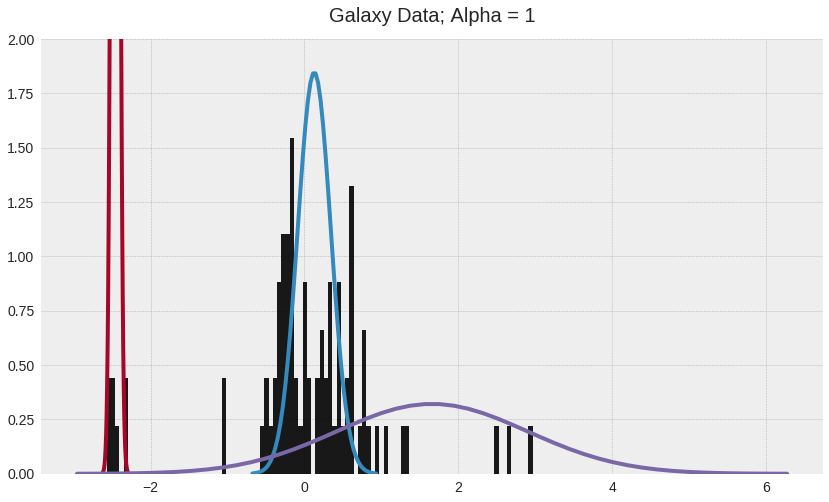

In [40]:
# Plot posterior distribution
plt.figure(figsize=(14,8))
for c in clusters:
    c_dist = D.norm(c.mu, c.std)
    x = np.linspace(c_dist.ppf(.0001), c_dist.ppf(.9999))
    plt.plot(x, c_dist.pdf(x), lw=4)
plt.ylim(0, 2)
plt.hist(galaxy, bins=100, color='k', alpha=0.9, normed=True)
plt.title('Galaxy Data; Alpha = 1', fontsize=20, y=1.025)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

## Repeat without re-initialization

# EM

Comparison with an EM Gaussian Mixture model

In [11]:
from sklearn.mixture import GaussianMixture

In [25]:
model = GaussianMixture(n_components=4).fit(galaxy)

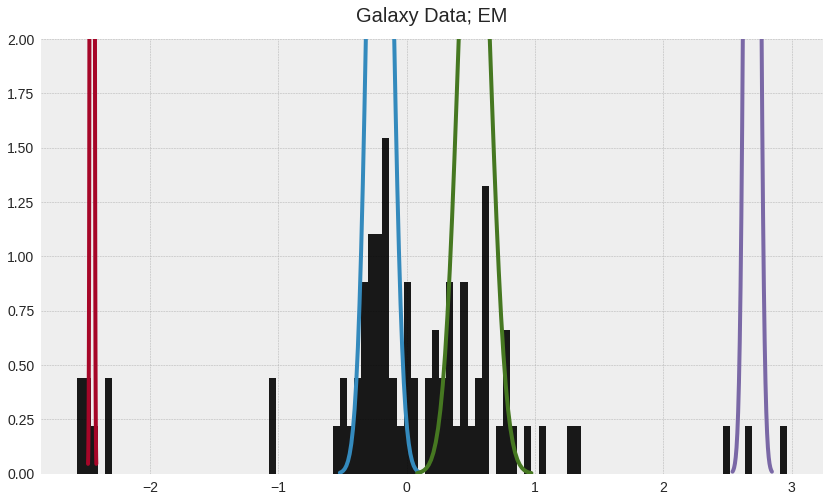

In [26]:
plt.figure(figsize=(14,8))
for mu, std in zip(model.means_.squeeze(), model.covariances_.squeeze()):
    c_dist = D.norm(mu, std)
    x = np.linspace(c_dist.ppf(.0001), c_dist.ppf(.9999))
    plt.plot(x, c_dist.pdf(x), lw=4)
plt.ylim(0, 2)
plt.hist(galaxy, bins=100, color='k', alpha=0.9, normed=True)
plt.title('Galaxy Data; EM', fontsize=20, y=1.025)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

# Stick Breaking

In [14]:
import theano.tensor as tt

In [15]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

In [16]:
K = 30

In [17]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, observed=galaxy)

In [18]:
with model:
    trace = pm.sample(2000, n_init=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -2,482: 100%|██████████| 50000/50000 [00:29<00:00, 1668.32it/s]  
Finished [100%]: Average ELBO = -2,470.2
100%|██████████| 2000/2000 [07:09<00:00, 12.95it/s]


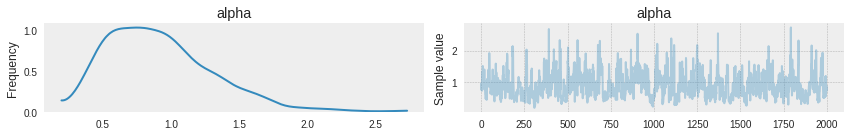

In [19]:
pm.traceplot(trace, varnames=['alpha']);

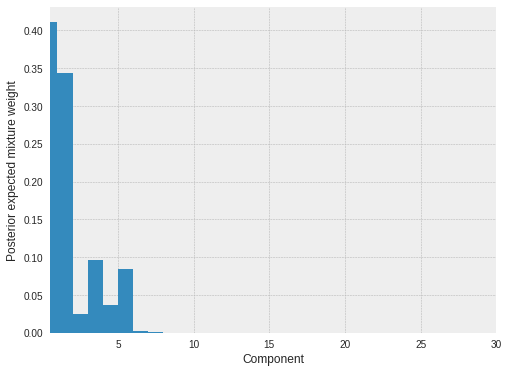

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [21]:
x_plot = np.linspace(-4, 4, 400)

In [22]:
post_pdf_contribs = D.norm.pdf(np.atleast_3d(x_plot), trace['mu'][:, np.newaxis, :], 1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

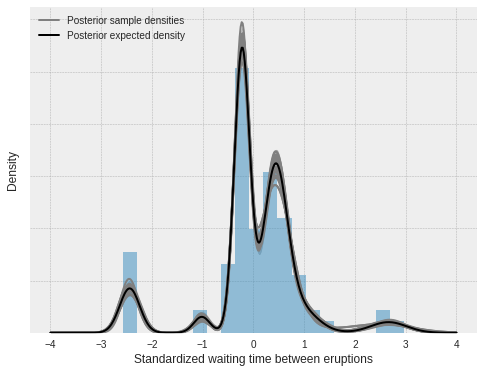

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(galaxy, bins=n_bins, normed=True, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

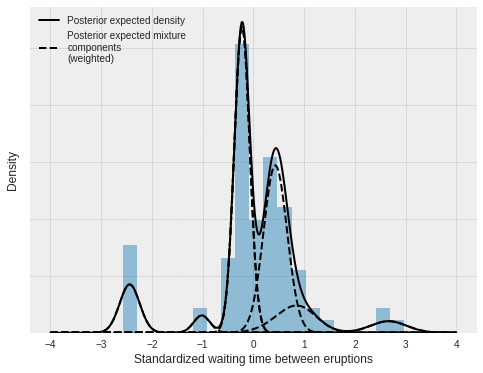

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(galaxy, bins=n_bins, normed=True, lw=0, alpha=0.5);

ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);